<a href="https://colab.research.google.com/github/Christina1281995/FinalAssignmentDSSG/blob/main/Final_Assignment_DSSG_Christina_Zorenboehmer_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning and Data Science for Social Good

<font color='grey'>By Christina Zorenböhmer | Matriculation number: 12040947</font>


This notebook is used to present a final assignment for a seminar course on bias in machine learning at the University of Salzburg. The assignment is split into 4 broad parts:


1. Context and Dataset
2. Machine Learning Classification
3. Aequitas Bias Audit
4. Interpretation and Recommendations for Bias Reduction





# <font color='cornflowerblue'> Part 1: Context and Dataset </font>

### Dataset

Adult Dataset to predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.

<b>Source: </b> The data was extracted from the census bureau database found at http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions
|    https://archive.ics.uci.edu/ml/datasets/adult



### Case Study

The use of a machine learning (ML) algorithm to predict whether or not an individual is likely to earn above or below 50k per year is often used in the context of banking credit evaluation schemes, e.g. to predict credit worthiness. This scenario will be the case study for my analysis of potential bias. 

<b>Scenario: </b>

The <i>'1996 Bank of Unfair'</i> is making use of a ML classifier to help make deiscions on whether an applicant can be considered credit worthy. Since the classifier is used to assess whether individuals stand to <b><font color='royalblue'>gain something</font></b>, it serves is an <b><font color='royalblue'>assistive</font></b> decision-support tool. This is an important first consideration that helps us analyse the dynamics of the many winners and losers of any decisions influenced by the classifier. In general, an assistive intervention should aim for <b><font color='royalblue'>false negative parity</font></b> so as to ensure that there is no bias among those who mistakenly are not awarded credit. 

In a previous homework, a few scnearios and potential consequences for credit worthiness predictions were assessed:




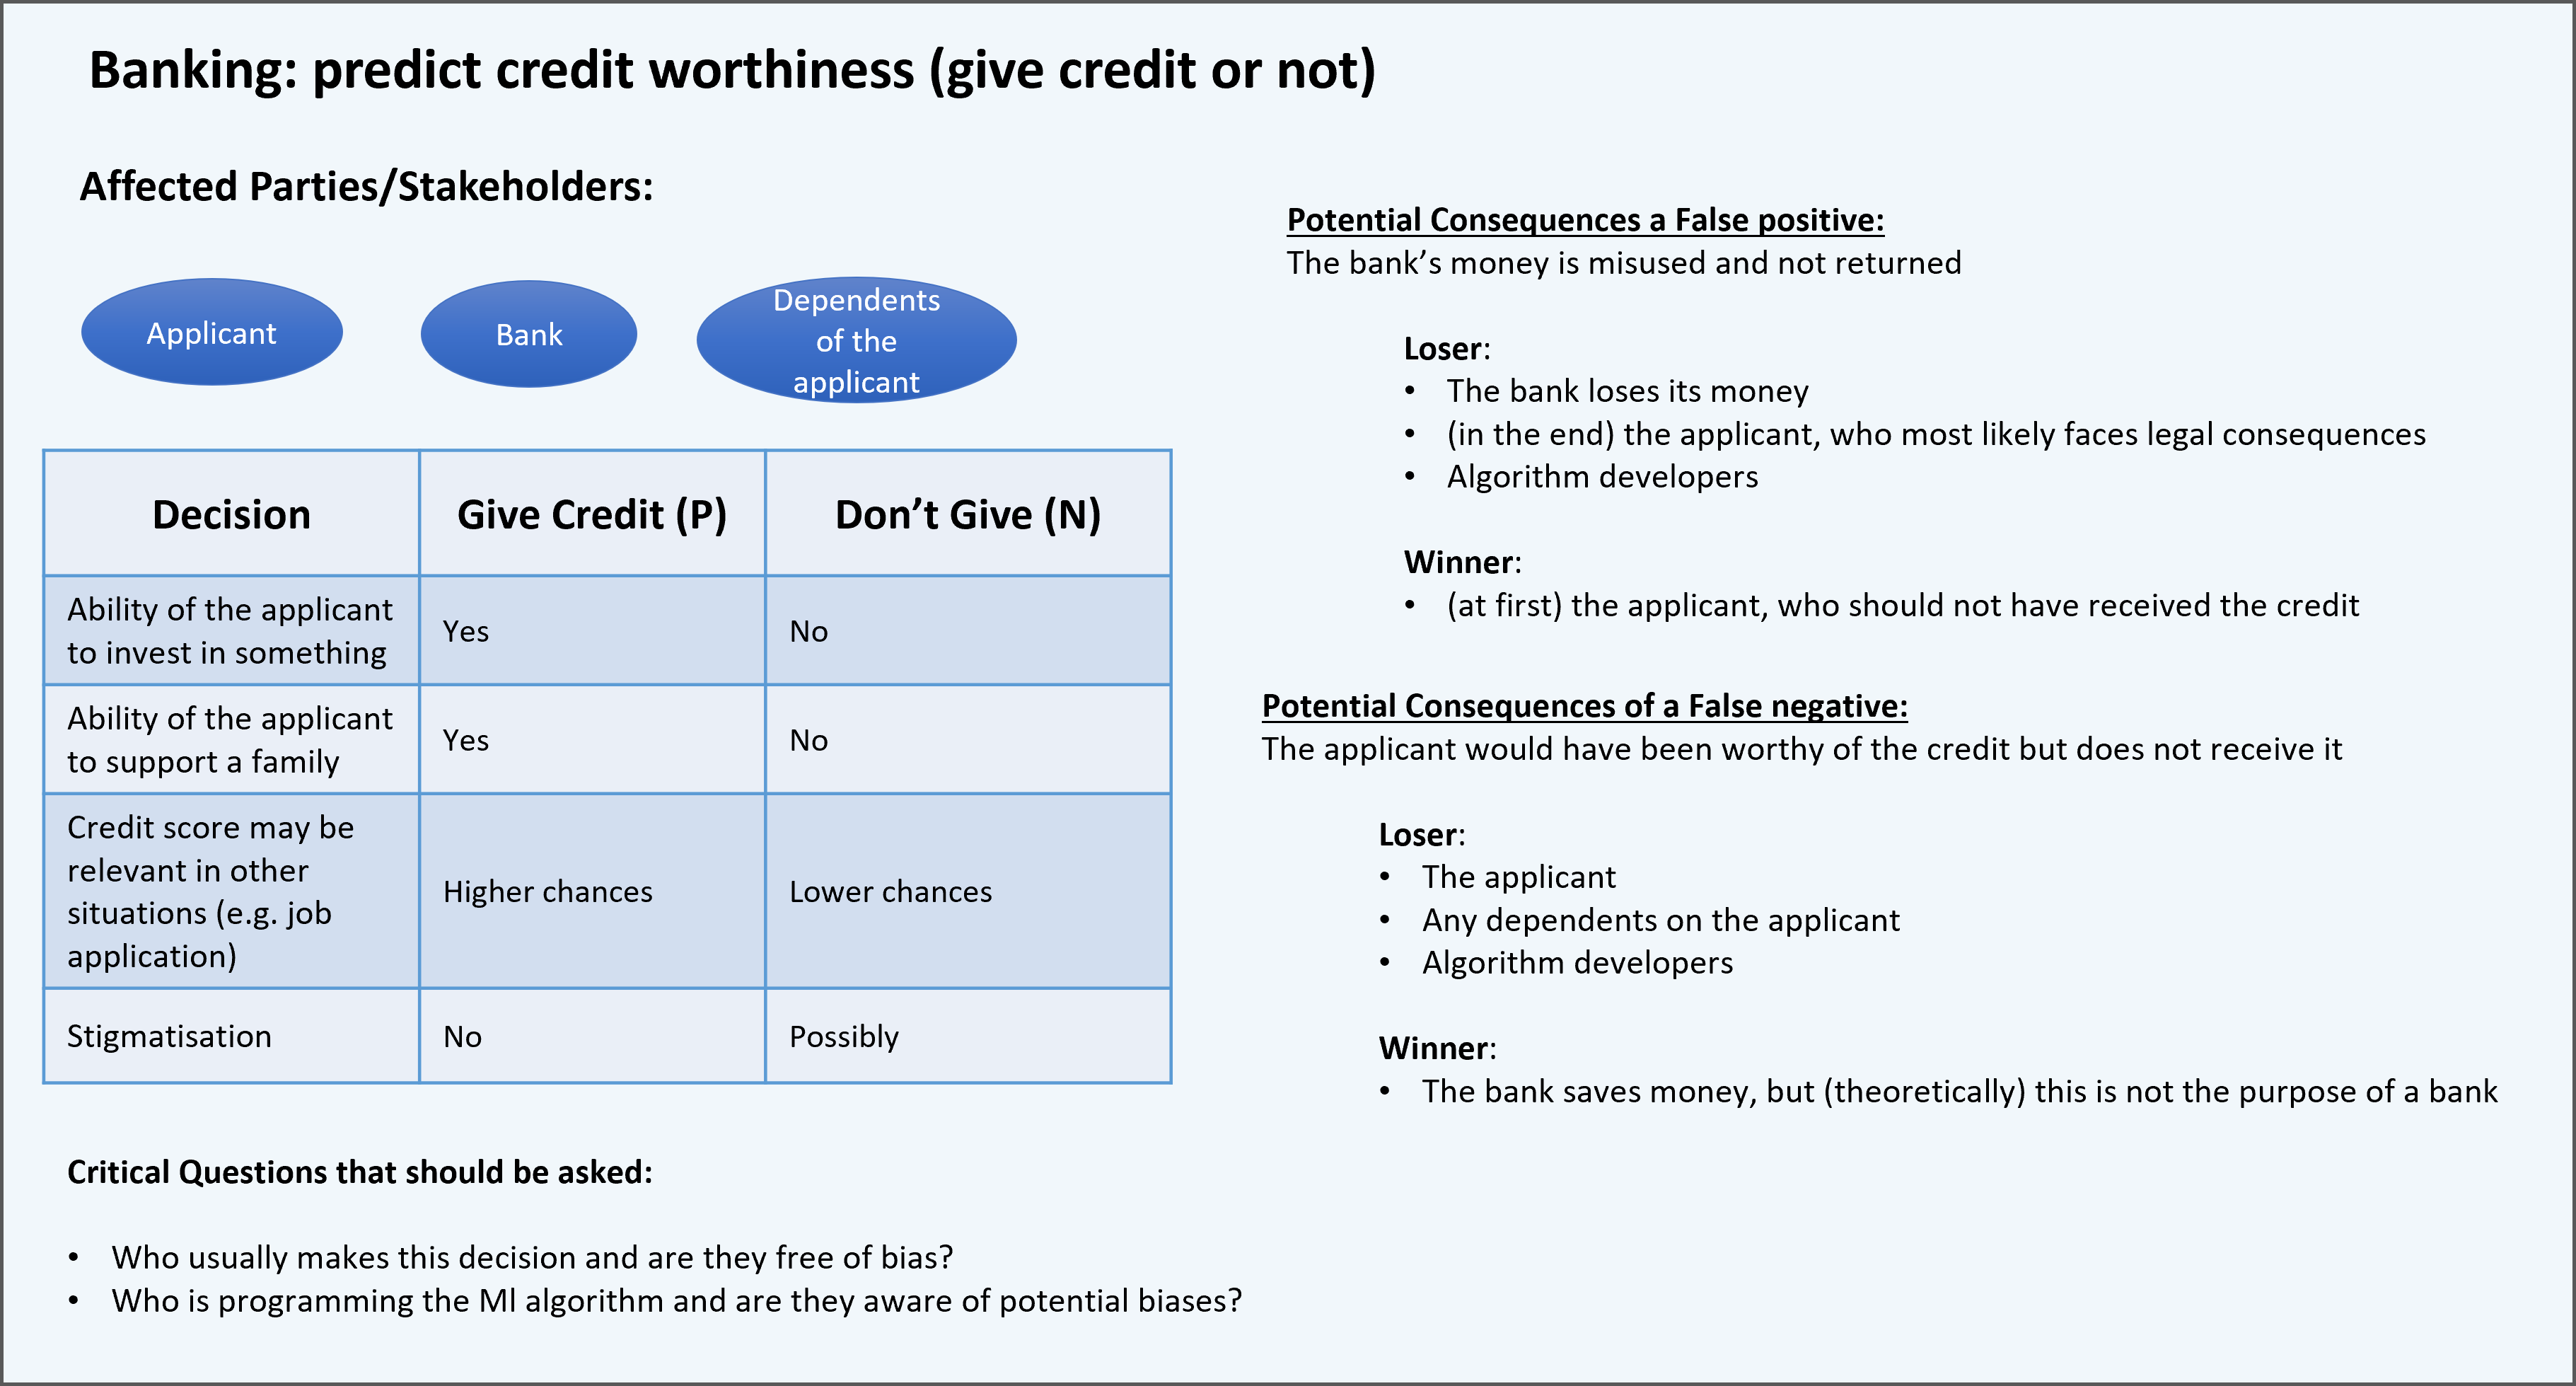

Following this brief initial conceptualisation of the scenario, we can draw a few conclusions about important factors:

- A <b><font color='royalblue'>false negative</font></b> is likely to have a <b><font color='royalblue'>more severe impact</font></b> on an individual's circumstances than a false positive which would be an unfair gain for someone who is not credit worthy but ultimately only harms the bank itself
   - Based on that, a first performance indicator that will be important to check for is the <b><font color='royalblue'>recall</font></b>, i.e. how many of the true positives does the classifier actually find. This indicator should be as high as possible.


- It matters who traditionally made these decisions and therefore created the existing system of credit worthiness judgements 
   - If their judgement was biased and the existing system for decisions on credit worthiness is unfair, then there is a <b><font color='royalblue'>risk of that bias flowing into the ML algorithm</font></b> if the programmers use existing indicators and datasets


- It matters who is creating an evaluating the Ml algorithm
   - A team of programmers who only represent one population group (e.g. white married men), they will inevitably incorporate their own perspectives in the classifier, whether or not they are aware of it
   - A <b><font color='royalblue'>diverse team of programmers</font></b> is more likely to think of all possible pitfalls and to consider all needs and scenarios affecting the diverse groups of people who stand to gain from this classifier
   
   


### Data Overview

Install required packages:

In [ ]:
!pip install aequitas
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

Let's take a look at the dataset:

In [ ]:
adult_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None)
adult_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Check how large the dataset is:

In [ ]:
adult_data.shape

(32561, 15)

Since the dataset is provided without and column names, let's add in appropriate headings:

In [ ]:
adult_data.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
adult_data.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Exploratory Data Analysis

Taking a good look at the dataset is an under-rated but really important first step. Just by looking at the data we can get some meaningful insights. The data sources, collection methods, or population group representations in the data are some of the most frequent causes of bias. 

Let's take a look at... 

... the age distribtuion in the dataset:

Text(0.5, 1.0, 'Age Histogram')

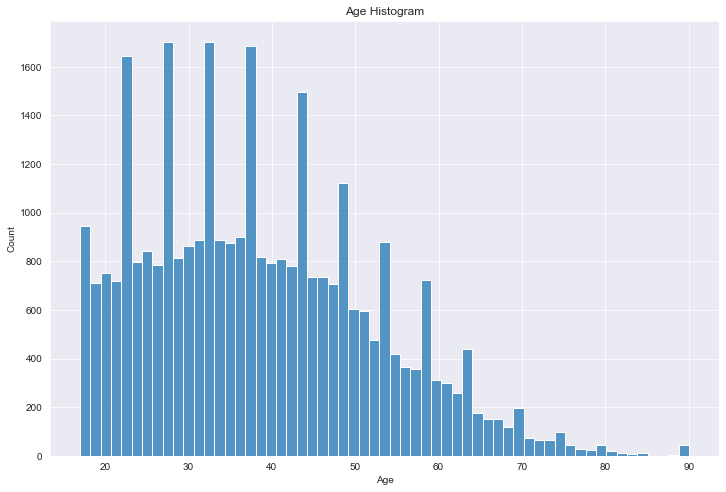

In [ ]:
# set figure size and style:
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style('darkgrid')
sns.histplot(adult_data.Age).set_title("Age Histogram")

... how different races are represented in the data:

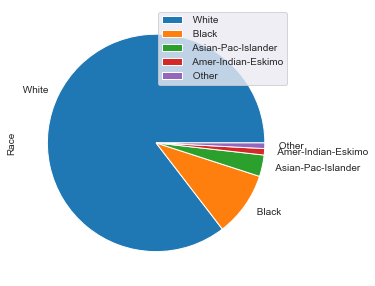

In [ ]:
x = pd.DataFrame(adult_data["Race"].value_counts())
plot = x.plot.pie(y="Race", figsize=(5,5))

... the levels of education:

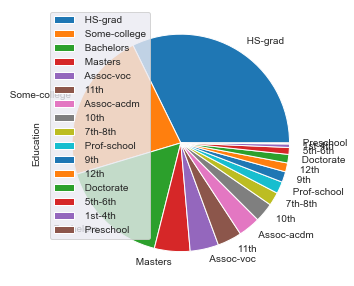

In [ ]:
x = pd.DataFrame(adult_data["Education"].value_counts())
plot = x.plot.pie(y="Education", figsize=(5,5))

... gender proportions:

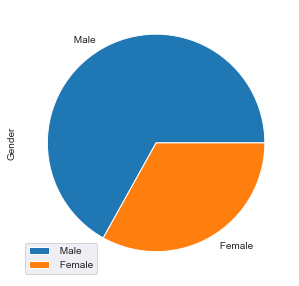

In [ ]:
x = pd.DataFrame(adult_data["Gender"].value_counts())
plot = x.plot.pie(y="Gender", figsize=(5,5))

... and finally, the actual income (categorised into above and below 50k a year):

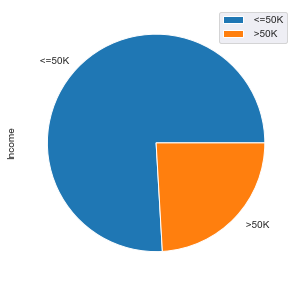

In [ ]:
x = pd.DataFrame(adult_data["Income"].value_counts())
plot = x.plot.pie(y="Income", figsize=(5,5))

Already we can obvserve a disproportionate representation of some population groups. Here I list a few of those and the concerns associated with them:

- The majority of the dataset is of <b><font color='royalblue'>men</font></b> > We should ask: Why is that? Have men traditionally been the ones to apply for benk credits in a family? And is that still the case today? 


- The majority of the dataset considers <b><font color='royalblue'>white people</font></b>  > We should ask: Does this accurately represent the population? Was this dataset collected from historical bank credit applications? If so, were other races systematically discouraged from applying? Does the data on other races provide a realistic representation of the population? Does the data on white people even represent a realistic representation of the true population or is it mostly white people who are high-earners? The issue of over-representation raises concerns about <b><font color='royalblue'>proportional parity</font></b>, which aims to ensure all classes represented according to their proportions in the true population. Most strikingly, <b><font color='royalblue'>an entire ethnicity seems to be missing: hispanics (today's 2nd largest ethnicity in the US)</font></b>.




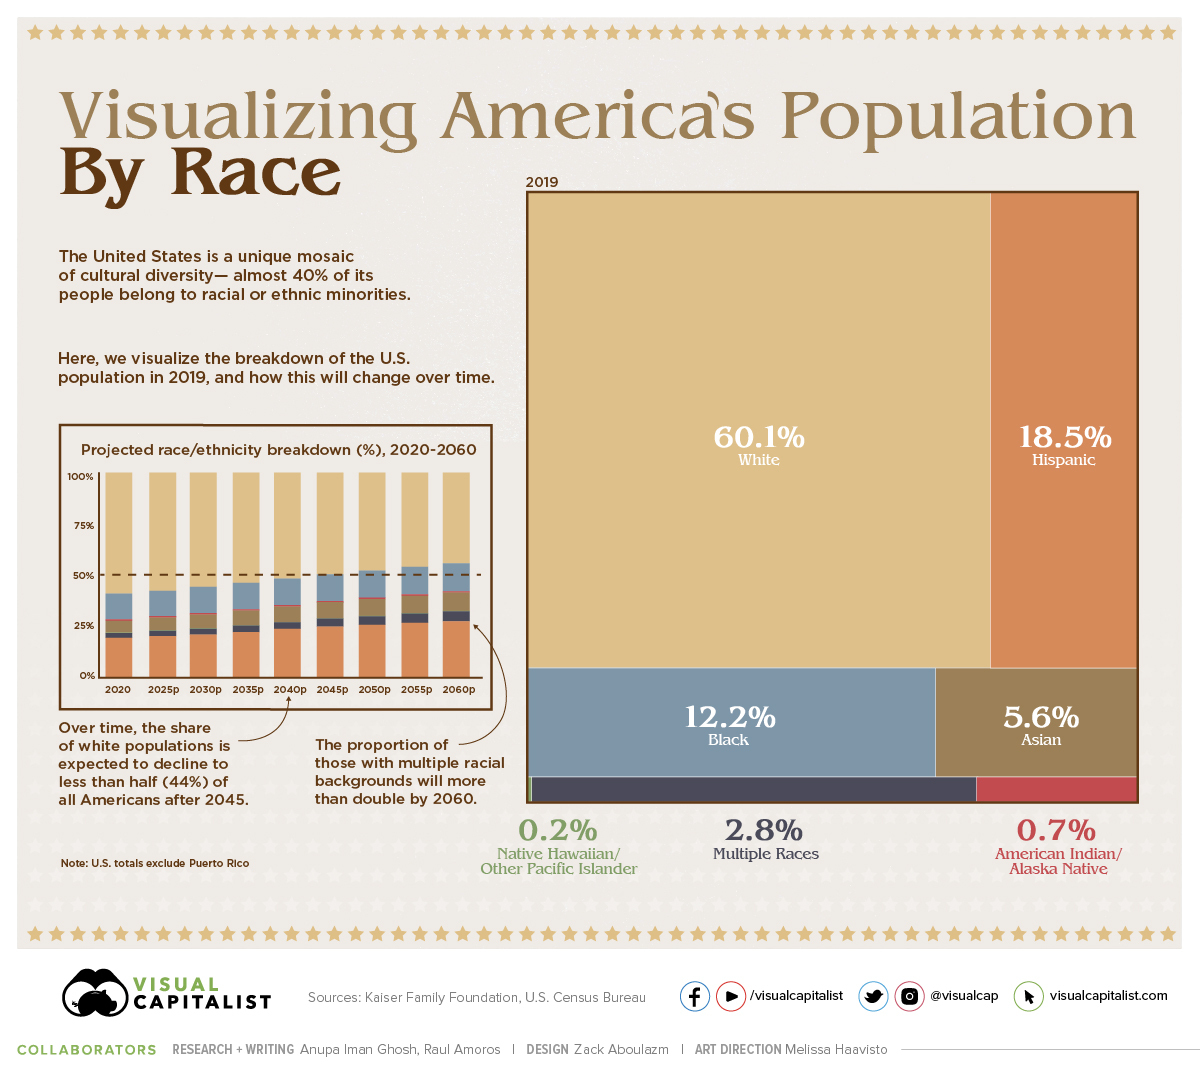


Ultimately these observations boil down to: <b><font color='royalblue'>Does the data collection method already include biases?</font></b> Let's look into it in some more detail.


The data stems from 1996, an era with a banking culture vastly different from today's, which already begs the question <b><font color='royalblue'>'Is this data even relevant anymore?'</font></b>. I would argue that it is not. Both women and non-white population groups were more excluded from the financial, banking sector 25 years ago. Racism was much more institutional than it is today and women are (nearly) are far more integrated in the workforce today meaning the percentage of women earning over 50K annually will be much larger today than in 1996. On a minor note, even the age distribution will have changed by now - life expectancy is slightly higher, the retirement age is higher, and the options for young people to earn above 50K is higher.


I would also argue that there are two biases related to data collection, which I list below:

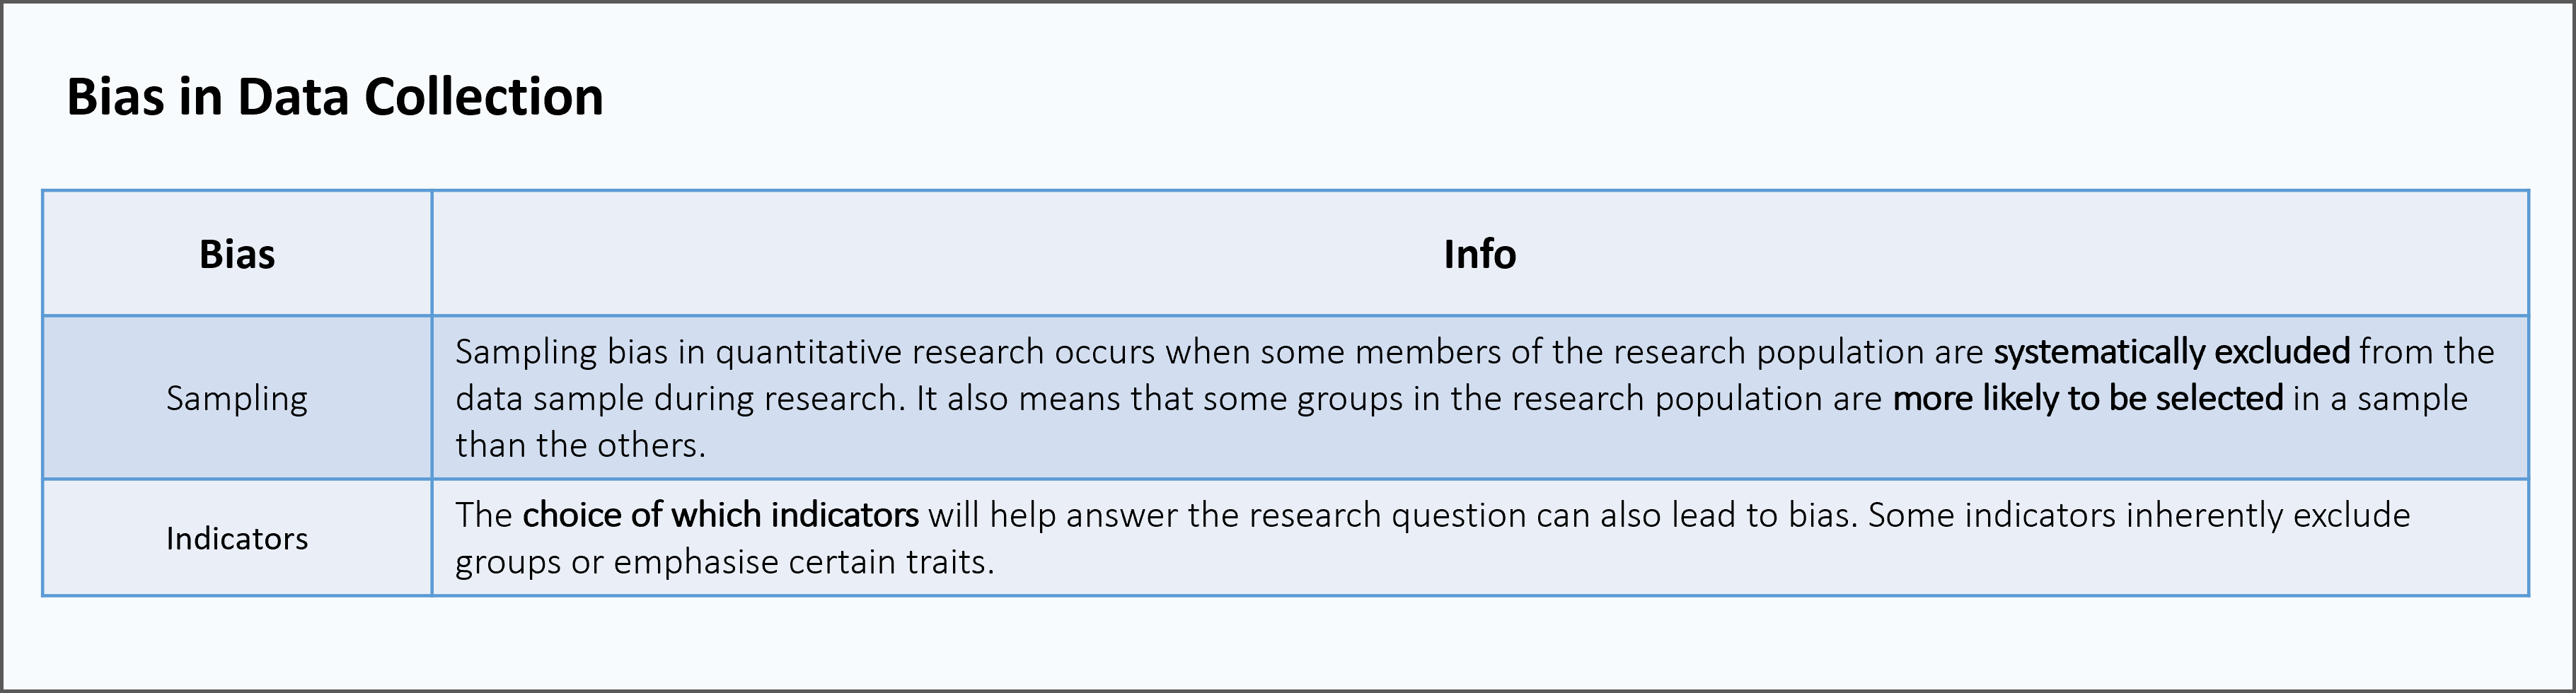

# <font color='cornflowerblue'>  Part 2: Machine Learning Classification </font>

With the aforementioned critiques in mind, the dataset was classified via the online platform <i>Rapidminer Go</i>

After comparing a few classification methods, three supervisesd classifiers that emphasise accuracy over speed were compared:
<font color='grey'><i>
1. neural networks (deep learning)
2. random forest
3. gradient boosted trees
    </i></font>

In the final selection emphasis was placed on the recall values, since we previously determined that it is more essential to get as many true positives right as possible. Based on performance indicators such as the confusion matrix and the ROC curve the <b><font color='royalblue'>gradient boosted tree classifier</font></b> was selected. Below are a few indicators that were used to obtain an initial assessment of the models:
    

### Model Comparisons in RapidMiner Go

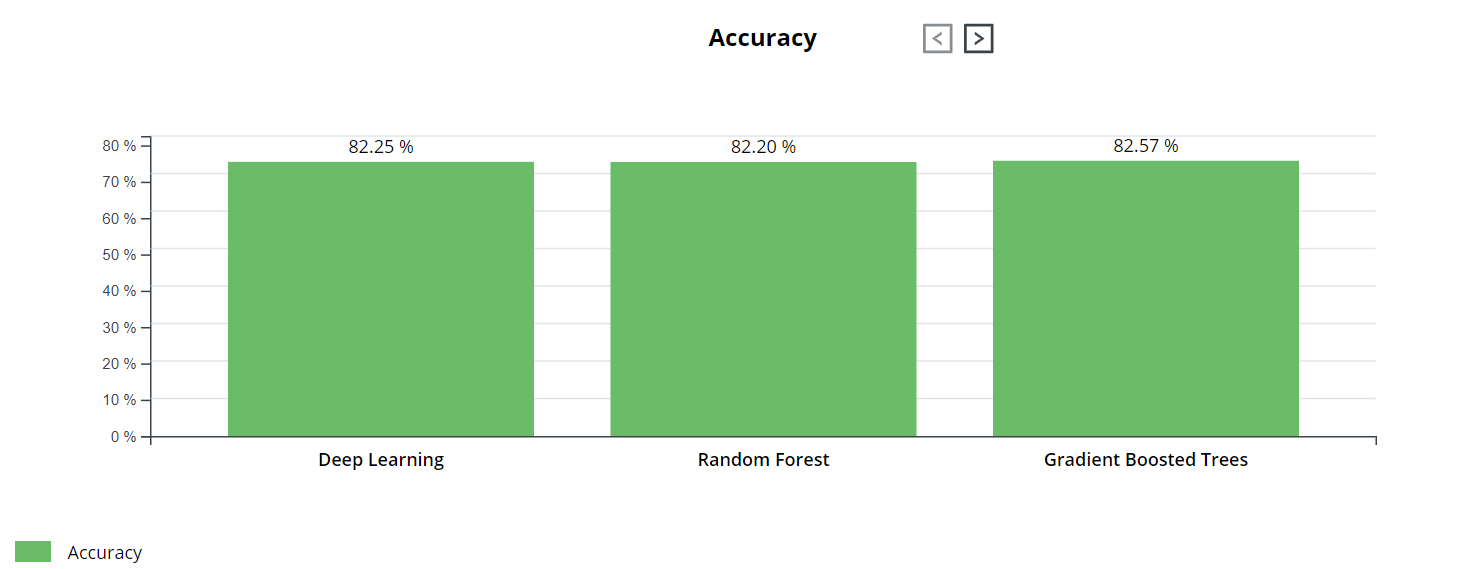

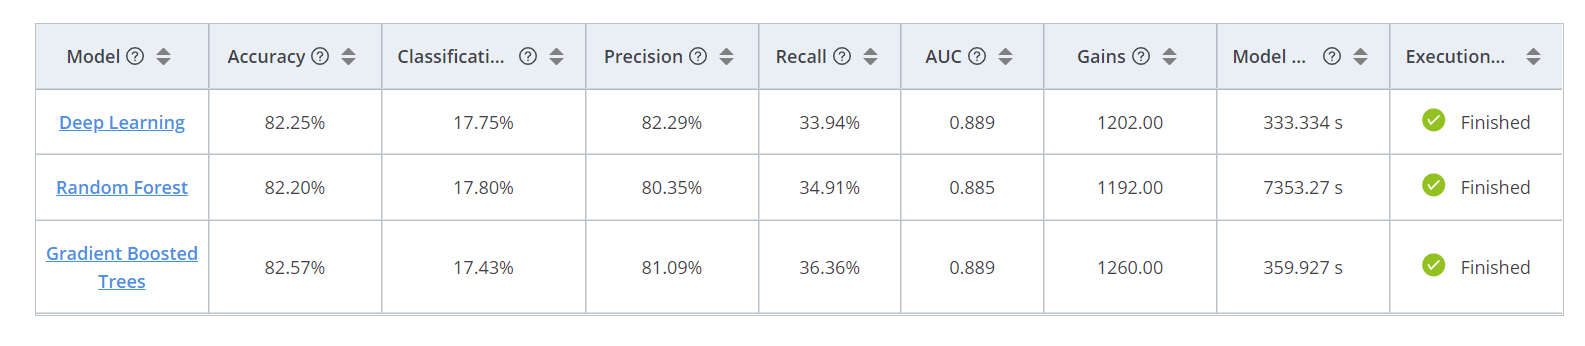

The gradient boosted trees model achieved higher recall values and was comparable in overall accuracy and AUC to the two other models.

<br>

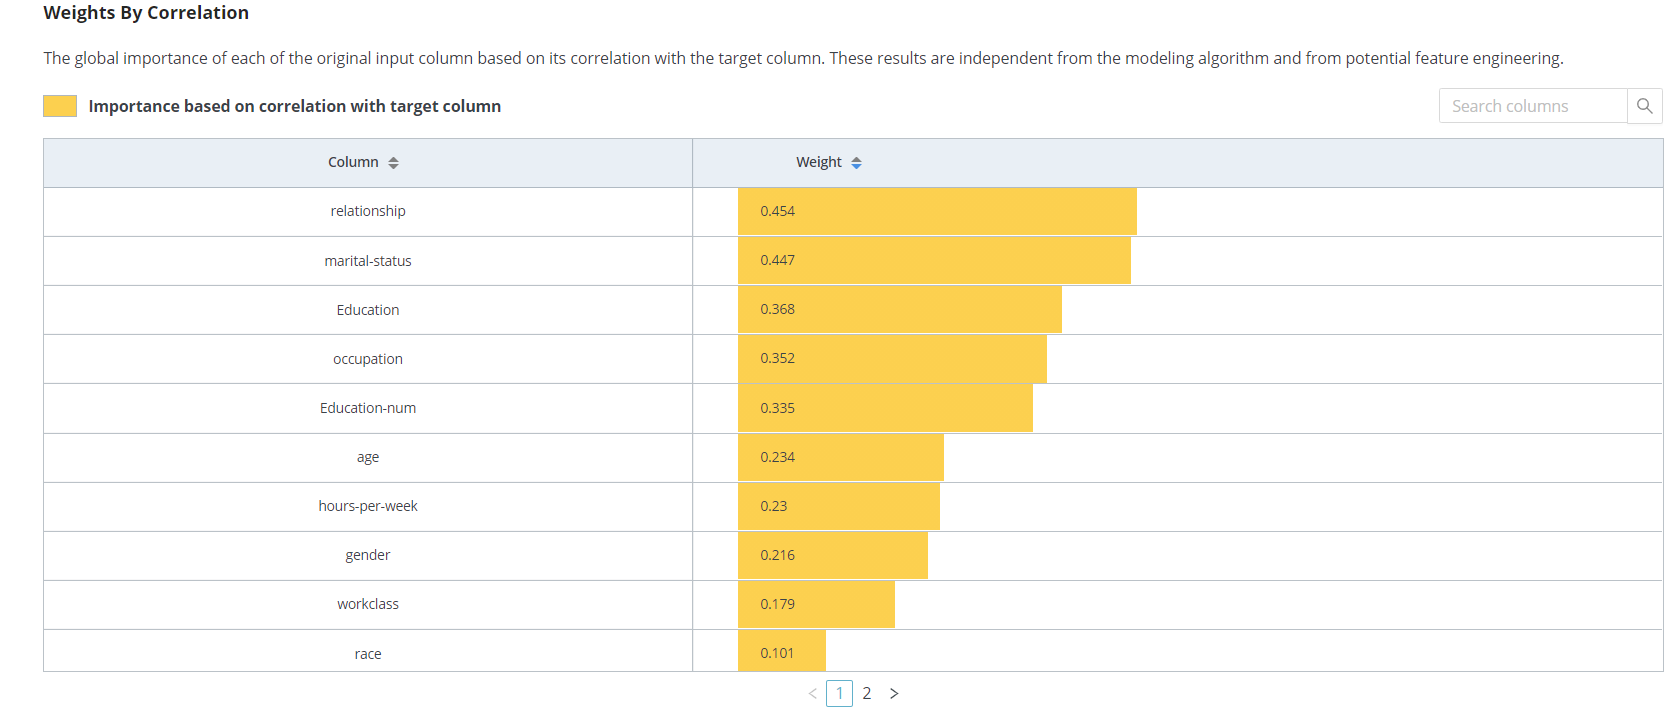

The weighting of the indicators brings me back to the issue of bias in the dataset. It appears that the relationship status has high influence on the classification, which should be critically considered given the gap of 25 years since the data collection and today's workforce, which consists of more indepenent workers.
  
  <br>

### Gradient Boosted Tree Classifier

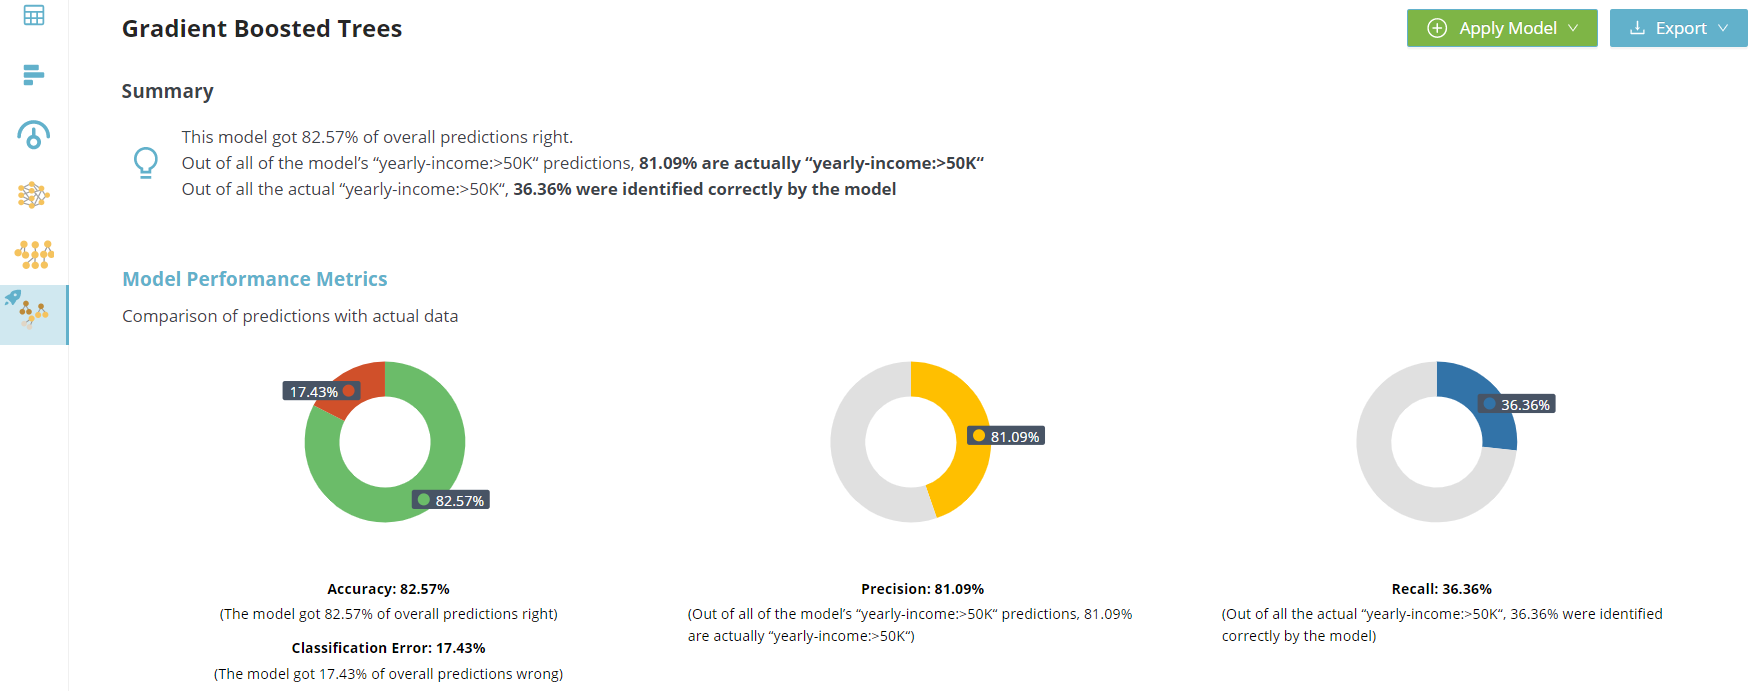

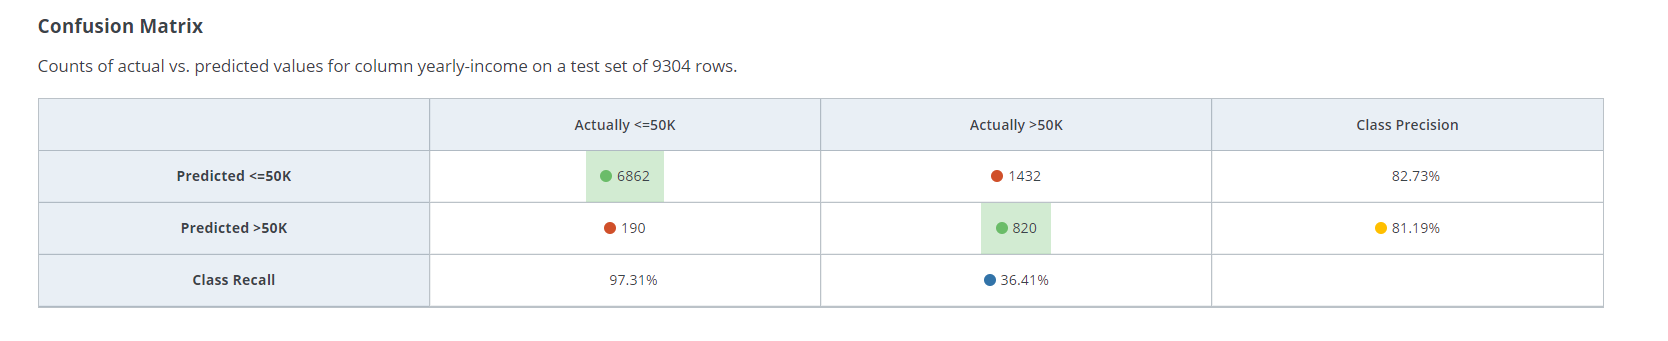

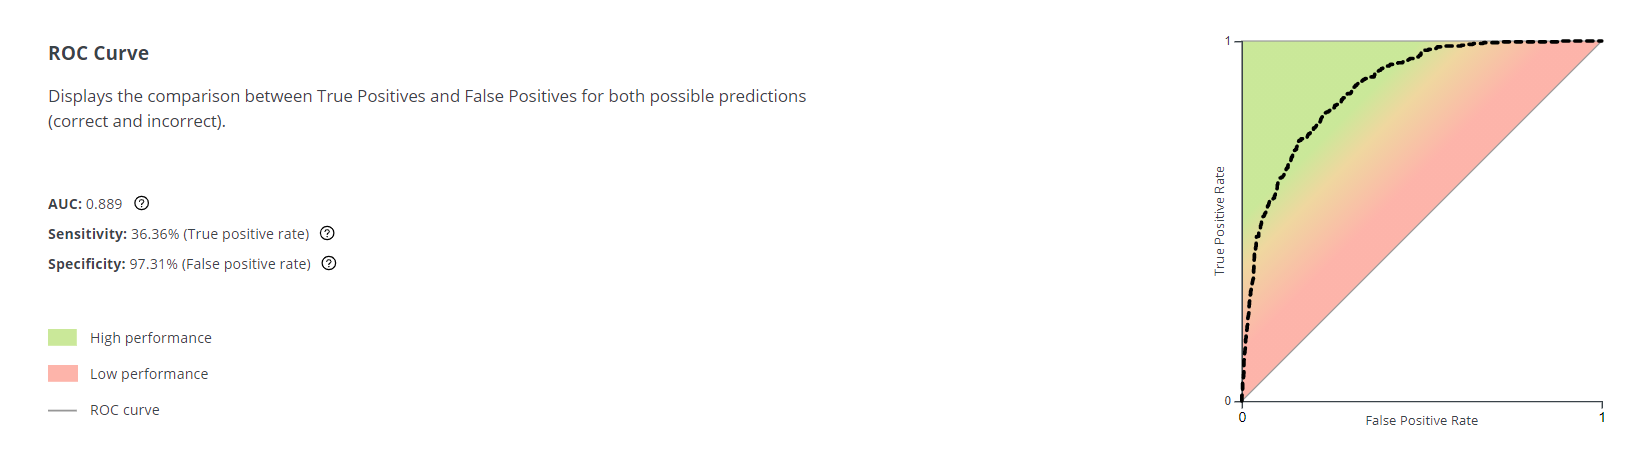

The ROC (Receiver Operator Characteristic) characterises the trade-off between a given model's sensitivity (= the true positive rate), and specificity (= the false positive rate). The diagonal reference line describes a completely random performance. 
The aim is therefore to generate a model that streches into the upper left-hand corner, thereby increasing the AUC (area under curve). 
<br>

The selected gradient boosted tree model achieves an AUC of 0.889, meaning that it is able to achieve a good trade-off. 

  <br>

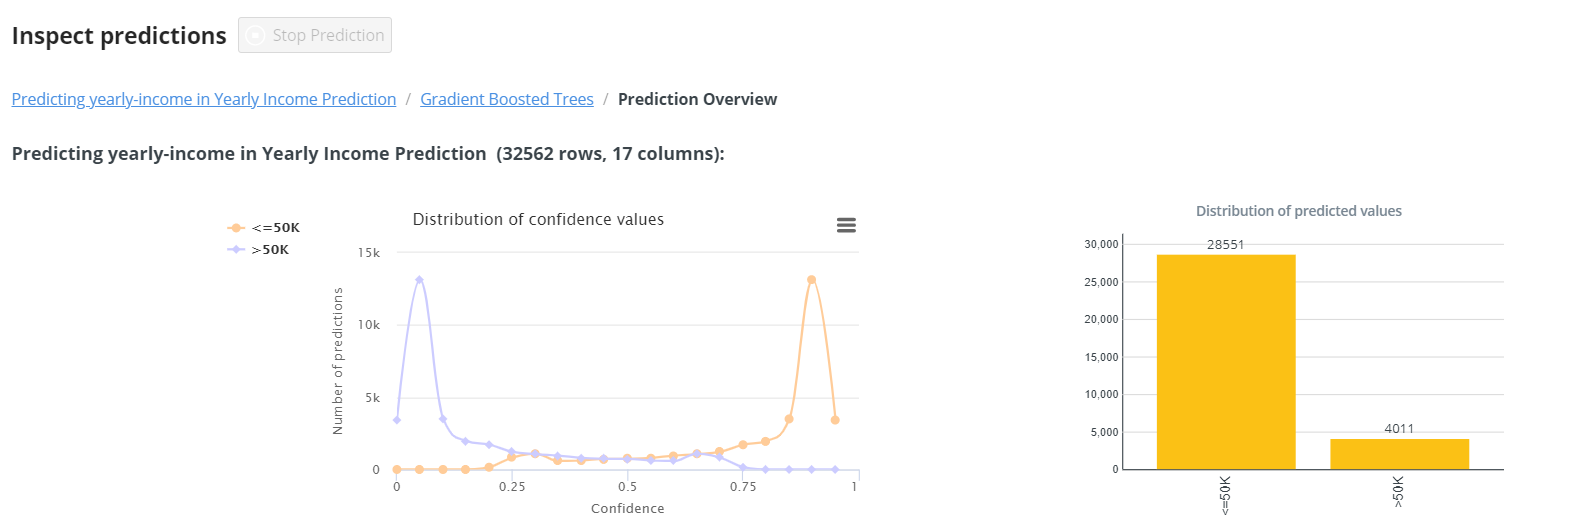

The confidence values tell us that the model is mostly certain about its classifiction. 

# <font color='cornflowerblue'>  Part 3: Aequitas Bias Audit </font>

<b>Data Preparation: </b> 

1. The machine learning classification results were added to the original dataset
2. The column labels were adjusted to match the requirements of Aequitas, i.e. the ground truth column (= income) was labelled "Label_value" and the predictions were labelled as "Score"

<br>
Let's load the new dataset with the predictions:

In [ ]:
prediction_data = pd.read_csv("https://cfd1e30b-0883-46cc-aa24-b895a089c3b2.filesusr.com/ugd/fba136_b80e8ff12b684ade8ec816084c90f42a.csv?dn=prediction_result_adjusted2.csv")
prediction_data.head()

,fnlwgt,captial-gain,capital-loss,Label_value,confidence(<=50K),confidence(>50K),Score,cost,Support Prediction,Contradict Prediction,...,Education,marital-status,occupation,relationship,race,gender,native-country,age,Education-num,hours-per-week
0,77516,2174,0,<=50K,0.864586,0.135414,<=50K,0.729172,relationship = Not-in-family (0.223); marital-...,age = 39 (-0.339); Education = Bachelors (-0.3...,...,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,39,13,40
1,83311,0,0,<=50K,0.640588,0.359412,<=50K,0.281177,gender = Male (0.056),relationship = Husband (-0.351); Education = B...,...,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,50,13,13
2,215646,0,0,<=50K,0.935112,0.064888,<=50K,0.870225,Education = HS-grad (0.222); relationship = No...,age = 38 (-0.359); Education-num = 9 (-0.195);...,...,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,38,9,40
3,234721,0,0,<=50K,0.916137,0.083863,<=50K,0.832275,Education = 11th (0.183); race = Black (0.137)...,relationship = Husband (-0.386); marital-statu...,...,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,53,7,40
4,338409,0,0,<=50K,0.501770,0.498230,<=50K,0.003540,race = Black (0.117); relationship = Wife (0.0...,age = 28 (-0.433); Education = Bachelors (-0.2...,...,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,28,13,40


Control the dataset is still the correct size:

In [ ]:
prediction_data.shape

(32561, 21)

### Exploring Predictions Vs. Ground Truth

A first look at how the model's predictions compare to the ground truth will help us see where the classification has strong and weak points. <b><font color='royalblue'>Let's compare a few key categories of interest: Race, Gender, and Relationship.</font></b>

<br>

General Settings for data display:

In [ ]:
# colors settings:
aq_palette = sns.diverging_palette(225, 35, n=2)
# adapt figure sizes:
plt.rcParams['figure.figsize'] = [12, 8]

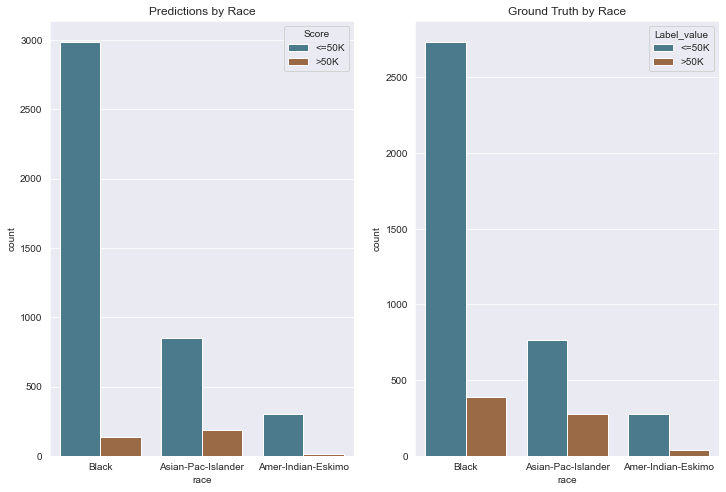

In [ ]:
fig, ax = plt.subplots(1,2)
pred_by_race = sns.countplot(x="race", hue="Score", data=prediction_data[prediction_data.race.isin(['Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Black'])], palette=aq_palette, ax=ax[0]).set_title('Predictions by Race')
truth_by_race = sns.countplot(x="race", hue="Label_value", data=prediction_data[prediction_data.race.isin(['Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Black'])], palette=aq_palette, ax=ax[1]).set_title('Ground Truth by Race')

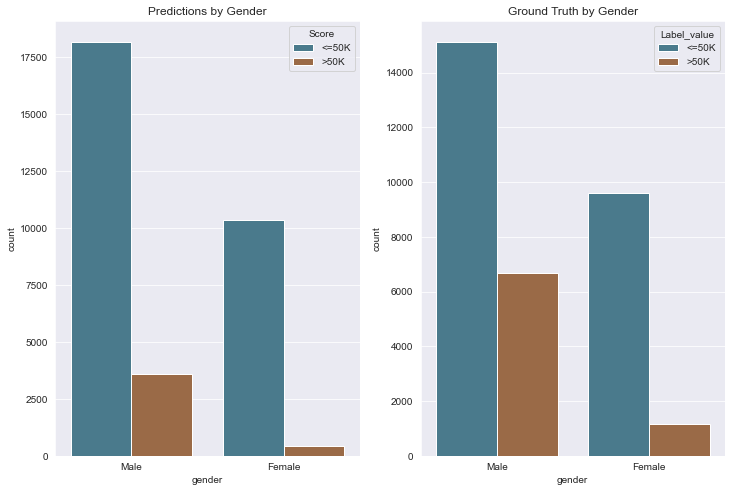

In [ ]:
fig, ax = plt.subplots(1,2)
pred_by_race = sns.countplot(x="gender", hue="Score", data=prediction_data[prediction_data.gender.isin(['Female', 'Male'])], palette=aq_palette, ax=ax[0]).set_title('Predictions by Gender')
truth_by_race = sns.countplot(x="gender", hue="Label_value", data=prediction_data[prediction_data.gender.isin(['Female', 'Male'])], palette=aq_palette, ax=ax[1]).set_title('Ground Truth by Gender')

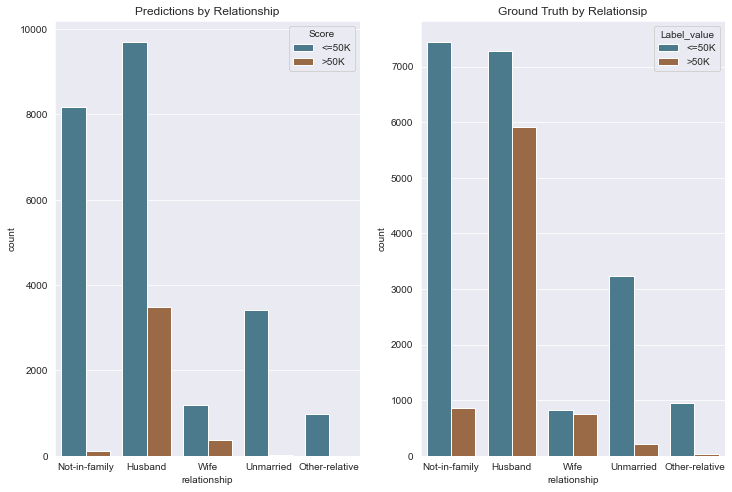

In [ ]:
fig, ax = plt.subplots(1,2)
pred_by_race = sns.countplot(x="relationship", hue="Score", data=prediction_data[prediction_data.relationship.isin(['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'])], palette=aq_palette, ax=ax[0]).set_title('Predictions by Relationship')
truth_by_race = sns.countplot(x="relationship", hue="Label_value", data=prediction_data[prediction_data.relationship.isin(['Wife', 'Own-child', 'Husband', 'Not-in-family', 'Other-relative', 'Unmarried'])], palette=aq_palette, ax=ax[1]).set_title('Ground Truth by Relationsip')

Just by comparing the predictions and ground truth values visually, we can tell that this classifier will not be a particularly good help for the <i>'1996 Bank of Unfair'</i>. The predictions for '>50K' are consistenly lower than the ground truth, but especially severe for unmarried or not-in-family individuals, black individuals, and both men and women. 

Next, let's use the Aequitas classes to dig a bit deeper.

## Aequitas Classes

The aequitas tool consideres three broad steps as python classes when checking for unfairness and bias:
<i><font color='grey'>
- Group(): Define groups

- Bias(): Calculate disparities

- Fairness(): Assert fairness
    </font></i>
This step required some additionl data pre-processing. In particular, the "Score" and "Label_value" column headers had to be changed to lowercase, and the data values changed into binary data types, and the dataset was reduced to only include attributes of interest that contain non-numerical values.

In [ ]:
# rename headings
prediction_data_new = prediction_data.rename(columns={'Score': 'score', 'Label_value': 'label_value'})
prediction_data_new.head()

,fnlwgt,captial-gain,capital-loss,label_value,confidence(<=50K),confidence(>50K),score,cost,Support Prediction,Contradict Prediction,...,Education,marital-status,occupation,relationship,race,gender,native-country,age,Education-num,hours-per-week
0,77516,2174,0,<=50K,0.864586,0.135414,<=50K,0.729172,relationship = Not-in-family (0.223); marital-...,age = 39 (-0.339); Education = Bachelors (-0.3...,...,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,39,13,40
1,83311,0,0,<=50K,0.640588,0.359412,<=50K,0.281177,gender = Male (0.056),relationship = Husband (-0.351); Education = B...,...,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,50,13,13
2,215646,0,0,<=50K,0.935112,0.064888,<=50K,0.870225,Education = HS-grad (0.222); relationship = No...,age = 38 (-0.359); Education-num = 9 (-0.195);...,...,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,38,9,40
3,234721,0,0,<=50K,0.916137,0.083863,<=50K,0.832275,Education = 11th (0.183); race = Black (0.137)...,relationship = Husband (-0.386); marital-statu...,...,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,53,7,40
4,338409,0,0,<=50K,0.501770,0.498230,<=50K,0.003540,race = Black (0.117); relationship = Wife (0.0...,age = 28 (-0.433); Education = Bachelors (-0.2...,...,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,28,13,40


In [ ]:
# turn score and label_value into binary datasets
prediction_data_new["label_value"] = prediction_data_new["label_value"].map({ "<=50K": 0, ">50K": 1 })
prediction_data_new["score"] = prediction_data_new["score"].map({ "<=50K": 0, ">50K": 1 })
prediction_data_new.head()

,fnlwgt,captial-gain,capital-loss,label_value,confidence(<=50K),confidence(>50K),score,cost,Support Prediction,Contradict Prediction,...,Education,marital-status,occupation,relationship,race,gender,native-country,age,Education-num,hours-per-week
0,77516,2174,0,0,0.864586,0.135414,0,0.729172,relationship = Not-in-family (0.223); marital-...,age = 39 (-0.339); Education = Bachelors (-0.3...,...,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,39,13,40
1,83311,0,0,0,0.640588,0.359412,0,0.281177,gender = Male (0.056),relationship = Husband (-0.351); Education = B...,...,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,50,13,13
2,215646,0,0,0,0.935112,0.064888,0,0.870225,Education = HS-grad (0.222); relationship = No...,age = 38 (-0.359); Education-num = 9 (-0.195);...,...,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,38,9,40
3,234721,0,0,0,0.916137,0.083863,0,0.832275,Education = 11th (0.183); race = Black (0.137)...,relationship = Husband (-0.386); marital-statu...,...,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,53,7,40
4,338409,0,0,0,0.501770,0.498230,0,0.003540,race = Black (0.117); relationship = Wife (0.0...,age = 28 (-0.433); Education = Bachelors (-0.2...,...,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,28,13,40


In [ ]:
# use only score, label_value and any non-numerical attributes of interest
prediction_format = pd.DataFrame()
prediction_format = prediction_data_new[['score', 'label_value', 'gender', 'race', 'relationship']]
prediction_format.head()

,score,label_value,gender,race,relationship
0,0,0,Male,White,Not-in-family
1,0,0,Male,White,Husband
2,0,0,Male,White,Not-in-family
3,0,0,Male,Black,Husband
4,0,0,Female,Black,Wife


### Aequitas Group() Class

In [ ]:
g = Group()
xtab, _ = g.get_crosstabs(prediction_format)

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [ ]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,4011,gender,Female,409,10362,98,868,9494,311,1179,9592,10771,32561
1,0,binary 0/1,4011,gender,Male,3602,18188,760,3820,14368,2842,6662,15128,21790,32561
2,0,binary 0/1,4011,race,Amer-Indian-Eskimo,12,299,2,26,273,10,36,275,311,32561
3,0,binary 0/1,4011,race,Asian-Pac-Islander,188,851,54,142,709,134,276,763,1039,32561
4,0,binary 0/1,4011,race,Black,135,2989,34,286,2703,101,387,2737,3124,32561
5,0,binary 0/1,4011,race,Other,10,261,3,18,243,7,25,246,271,32561
6,0,binary 0/1,4011,race,White,3666,24150,765,4216,19934,2901,7117,20699,27816,32561
7,0,binary 0/1,4011,relationship,Husband,3490,9703,732,3160,6543,2758,5918,7275,13193,32561
8,0,binary 0/1,4011,relationship,MISSING,1,5067,0,66,5001,1,67,5001,5068,32561
9,0,binary 0/1,4011,relationship,Not-in-family,122,8183,32,766,7417,90,856,7449,8305,32561


Below the ratios:

In [ ]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,gender,Female,0.26,0.99,0.08,0.24,0.01,0.74,0.92,0.76,0.10,0.04,0.11
1,gender,Male,0.43,0.95,0.21,0.21,0.05,0.57,0.79,0.79,0.90,0.17,0.31
2,race,Amer-Indian-Eskimo,0.28,0.99,0.09,0.17,0.01,0.72,0.91,0.83,0.00,0.04,0.12
3,race,Asian-Pac-Islander,0.49,0.93,0.17,0.29,0.07,0.51,0.83,0.71,0.05,0.18,0.27
4,race,Black,0.26,0.99,0.10,0.25,0.01,0.74,0.90,0.75,0.03,0.04,0.12
5,race,Other,0.28,0.99,0.07,0.30,0.01,0.72,0.93,0.70,0.00,0.04,0.09
6,race,White,0.41,0.96,0.17,0.21,0.04,0.59,0.83,0.79,0.91,0.13,0.26
7,relationship,Husband,0.47,0.90,0.33,0.21,0.10,0.53,0.67,0.79,0.87,0.26,0.45
8,relationship,MISSING,0.01,1.00,0.01,0.00,0.00,0.99,0.99,1.00,0.00,0.00,0.01
9,relationship,Not-in-family,0.11,1.00,0.09,0.26,0.00,0.89,0.91,0.74,0.03,0.01,0.10


Next, the <b><font color='royalblue'>Fairness Tree</font></b> can help guide us towards the most important indicators for fairness or bias in our model.


Based on fairness tree it emerges that "false negative rate parity" (FNR) is most important to consider. This strongly aligns with previous arguments on emphasising low false negatives. This indicator helps us focus on those with need. A lower value tells us that less false negatives occurred, hence we aim for low FNR.

Based on previous general considerations of the case study, also the recall/sensitivity (TPR) rate i.e. sensitivity is important, to see how much of the true positives the model actually captures. The reasoning behind this is the same as above and the TPR is actually very closely related to the FNR. For TPR we aim for high values.

Above, we see these ratios for each group of interest. 

- For <b><font color='royalblue'>False Negative Rate, FNR</font></b>:
   - Women achieve a worse rate compared to men: 0.74 vs 0.57
   - The groups 'white' and 'asian-pac-islander' achieve far better rates compared to black, other, and amer-indian-eskimo. Especially asian-pac-islanders achieve an FNR 23 percentage points below that of black people.
   - For all relationship groups, the FNR is suboptimal, but this reaches extreme rates for unmarried, other-relative, and not-in-family, all of which have an rate above 0.89.
   

- For <b><font color='royalblue'>Recall, TPR, </font></b>the same image emerges:
   - The results of the model show worse recall values for women compared to men: 0.26 vs 0.43. 
   - recall is over 10 percentage points lower for black, other, and amer-indian-eskimo groups, compared to asian-pac-islander and white
   - recall is actually terrible for all relationship statuses aside from "husband" and "wife" which score 0.47 and 0.38 respecitively, while not-in-family score 0.11, unmarries scores 0.09 and other-relative merely scores 0.03.


  

![Fairness-Full-Tree.png](attachment:Fairness-Full-Tree.png)

### Aequitas Bias() Class

This class helps us consider <b><font color='royalblue'>how these rates compare across our interest groups</font></b>. Above, we we able to draw some inital conclusions, but here we can directly juxtapose the FNR and TPR.

We first need to <b><font color='royalblue'>chose a 'reference group'</font></b> though, against which we can compare all other groups. We need to be careful when chosing a group as the 'reference' point though - in particular, it's important to be transparent about it and offer a good reason for the choice. 

I chose the following reference groups <b><font color='royalblue'>based on my  assumption</font></b> that they represent the largest groups in the true population of 'credit applicants' and also due to my assumption that they are the most fairly considered group (i.e. I assume, based on all of the above observations, that these groups are subject to the least bias and unfairness):

<i><font color='grey'>
- **Gender:**   Male
- **Race:**   White
- **Relationship:**   Husband
    </font></i>

In [ ]:
b = Bias()

In [ ]:
# set reference groups
bdf = b.get_disparity_predefined_groups(xtab, original_df=prediction_format, 
                                        ref_groups_dict={'gender' : 'Male', 'race':'White', 'relationship' : 'Husband'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,4011,gender,Female,0.263783,0.989783,0.083768,0.239609,0.010217,0.736217,0.916232,0.760391,409,10362,0.101970,0.037972,98,868,9494,311,1179,9592,10771,32561,0.109461,True,True,1.135620,Male,False,1.283947,Male,True,0.398839,Male,True,0.203369,Male,False,1.159830,Male,True,0.113548,Male,True,0.229710,Male,True,0.963733,Male,False,1.042138,Male,False,0.618340,Male,True
1,0,binary 0/1,4011,gender,Male,0.426599,0.949762,0.210029,0.210994,0.050238,0.573401,0.789971,0.789006,3602,18188,0.898030,0.165305,760,3820,14368,2842,6662,15128,21790,32561,0.305737,False,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False
2,0,binary 0/1,4011,race,Amer-Indian-Eskimo,0.277778,0.992727,0.086957,0.166667,0.007273,0.722222,0.913043,0.833333,12,299,0.002992,0.038585,2,26,273,10,36,275,311,32561,0.115756,True,True,0.798693,White,False,1.219178,White,True,0.498102,White,True,0.196782,White,False,1.106150,White,True,0.003273,White,True,0.292768,White,True,1.053085,White,False,1.030825,White,False,0.681470,White,True
3,0,binary 0/1,4011,race,Asian-Pac-Islander,0.485507,0.929227,0.166863,0.287234,0.070773,0.514493,0.833137,0.712766,188,851,0.046871,0.180943,54,142,709,134,276,763,1039,32561,0.265640,False,True,1.376471,White,True,0.868512,White,False,0.955818,White,False,1.914949,White,True,1.009344,White,False,0.051282,White,True,1.372918,White,True,0.900724,White,True,0.964887,White,True,1.191091,White,False
4,0,binary 0/1,4011,race,Black,0.260982,0.987578,0.095684,0.251852,0.012422,0.739018,0.904316,0.748148,135,2989,0.033657,0.043214,34,286,2703,101,387,2737,3124,32561,0.123880,True,True,1.206914,White,False,1.247531,White,True,0.548096,White,True,0.336118,White,False,1.095577,White,True,0.036825,White,True,0.327888,White,True,0.945436,White,False,1.025478,White,False,0.640265,White,True
5,0,binary 0/1,4011,race,Other,0.280000,0.987805,0.068966,0.300000,0.012195,0.720000,0.931034,0.700000,10,261,0.002493,0.036900,3,18,243,7,25,246,271,32561,0.092251,True,True,1.437647,White,False,1.215427,White,True,0.395047,White,True,0.329970,White,False,1.127946,White,True,0.002728,White,True,0.279984,White,True,0.884592,White,False,1.025714,White,False,0.686922,White,True
6,0,binary 0/1,4011,race,White,0.407616,0.963042,0.174576,0.208674,0.036958,0.592384,0.825424,0.791326,3666,24150,0.913987,0.131795,765,4216,19934,2901,7117,20699,27816,32561,0.255860,False,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False,1.000000,White,False
7,0,binary 0/1,4011,relationship,Husband,0.466036,0.899381,0.325672,0.209742,0.100619,0.533964,0.674328,0.790258,3490,9703,0.870107,0.264534,732,3160,6543,2758,5918,7275,13193,32561,0.448571,False,False,1.000000,Husband,False,1.000000,Husband,False,1.000000,Husband,False,1.000000,Husband,False,1.000000,Husband,False,1.000000,Husband,False,1.000000,Husband,False,1.000000,Husband,False,1.000000,Husband,False,1.000000,Husband,False
8,0,binary 0/1,4011,relationship,MISSING,0.014925,1.

In [ ]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,gender,Female,1.135620,1.283947,0.398839,0.203369,1.159830,0.113548,0.229710,0.963733,1.042138,0.618340,True,True,False,True,True,False,True,True,True,False,False,True
1,gender,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
2,race,Amer-Indian-Eskimo,0.798693,1.219178,0.498102,0.196782,1.106150,0.003273,0.292768,1.053085,1.030825,0.681470,True,True,False,True,True,False,True,True,True,False,False,True
3,race,Asian-Pac-Islander,1.376471,0.868512,0.955818,1.914949,1.009344,0.051282,1.372918,0.900724,0.964887,1.191091,False,True,True,False,False,True,False,True,True,True,True,False
4,race,Black,1.206914,1.247531,0.548096,0.336118,1.095577,0.036825,0.327888,0.945436,1.025478,0.640265,True,True,False,True,True,False,True,True,True,False,False,True
5,race,Other,1.437647,1.215427,0.395047,0.329970,1.127946,0.002728,0.279984,0.884592,1.025714,0.686922,True,True,False,True,True,False,True,True,True,False,False,True
6,race,White,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
7,relationship,Husband,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
8,relationship,MISSING,0.000000,1.844833,0.039996,0.000000,1.463643,0.000287,0.000746,1.265410,1.111875,0.032026,True,True,None,True,True,None,True,True,True,None,None,True
9,relationship,Not-in-family,1.250560,1.675880,0.287432,0.042695,1.344141,0.034957,0.055531,0.933499,1.107099,0.225605,True,True,False,True,True,False,True,True,True,False,False,True


In [ ]:
# set maximum tolerance value of divergence from reference group: 1.25
metrics = ['fnr','tpr']
disparity_tolerance = 1.25

<br>

<b>Aequitas Visualisations</b>

First we get an overview of 'fail' or 'pass' for each of the selected rates. You can hover your mouse over the circles to see which groups failed and passed the test for disparity from the reference group. The figure shows us that only in the category 'race' and the FNR all groups pass. 

In [ ]:
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

### Gender

We can visualise the comparison for certain categories too. Here we consider gender. The figures below show the grey points as the reference group, and their disparity is set to 1. In various colors, all other groups are shown in relation to the reference group. Any groups that fall into the red areas are beyond 1.25 time larger or smaller than the reference group.

<br>

In [ ]:
ap.disparity(bdf, metrics, 'gender', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

Check how the disparity threshold maps to the absolute values of each metric

In [ ]:
ap.absolute(bdf, metrics, 'gender', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

### Race

Check for disparities in Race:

In [ ]:
ap.disparity(bdf, metrics, 'race', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [ ]:
ap.absolute(bdf, metrics, 'race', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

### Relationship

Check for disparities in relationship:

In [ ]:
ap.disparity(bdf, metrics, 'relationship', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [ ]:
ap.absolute(bdf, metrics, 'relationship', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

<br>

### A Few Additional Visualisations 

The aequitas toolset also allows us to plot the various rates all in one figure. I have inserted some below. One thing these figures highlight is the apparent data quality issue of the 'missing' category in relationships. 

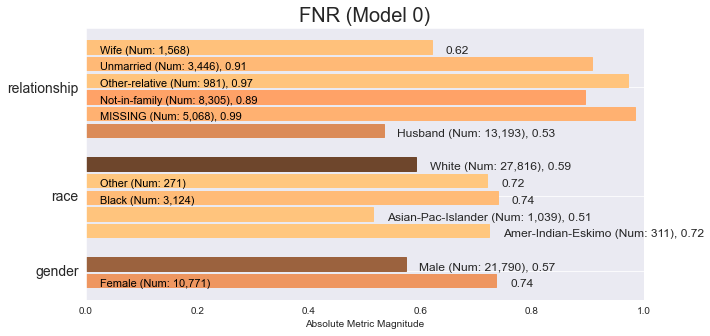

In [ ]:
from aequitas.plotting import Plot
aqp = Plot()
fnr_plot = aqp.plot_group_metric(xtab, 'fnr')

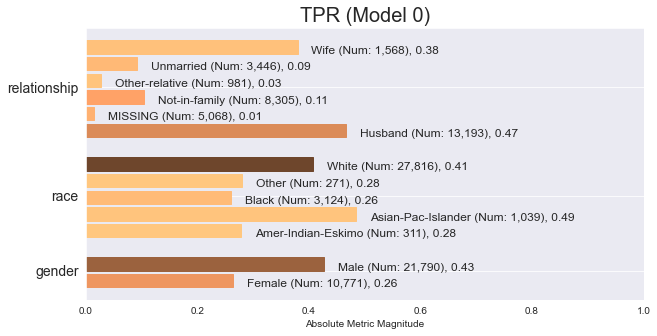

In [ ]:
tpr_plot = aqp.plot_group_metric(xtab, 'tpr')

### Aequitas Fairness() Class

Finally, the fairness class helps with some interpretation of the results. 

In [ ]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [ ]:
parity_detrminations = f.list_parities(fdf)

In [ ]:
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + b.list_disparities(fdf) + parity_detrminations].style

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,Equalized Odds,Supervised Fairness,TypeII Parity,Precision Parity,TypeI Parity,Impact Parity,FPR Parity,TNR Parity,FDR Parity,Statistical Parity,FNR Parity,Unsupervised Fairness,FOR Parity,TPR Parity,NPV Parity
0,gender,Female,0.263783,0.989783,0.083768,0.239609,0.010217,0.736217,0.916232,0.760391,0.101970,0.037972,0.109461,1.135620,1.283947,0.398839,0.203369,1.159830,0.113548,0.229710,0.963733,1.042138,0.618340,False,False,False,True,False,False,False,True,True,False,False,False,False,False,True
1,gender,Male,0.426599,0.949762,0.210029,0.210994,0.050238,0.573401,0.789971,0.789006,0.898030,0.165305,0.305737,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,race,Amer-Indian-Eskimo,0.277778,0.992727,0.086957,0.166667,0.007273,0.722222,0.913043,0.833333,0.002992,0.038585,0.115756,0.798693,1.219178,0.498102,0.196782,1.106150,0.003273,0.292768,1.053085,1.030825,0.681470,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True
3,race,Asian-Pac-Islander,0.485507,0.929227,0.166863,0.287234,0.070773,0.514493,0.833137,0.712766,0.046871,0.180943,0.265640,1.376471,0.868512,0.955818,1.914949,1.009344,0.051282,1.372918,0.900724,0.964887,1.191091,False,False,True,True,False,False,False,True,False,False,True,False,True,True,True
4,race,Black,0.260982,0.987578,0.095684,0.251852,0.012422,0.739018,0.904316,0.748148,0.033657,0.043214,0.123880,1.206914,1.247531,0.548096,0.336118,1.095577,0.036825,0.327888,0.945436,1.025478,0.640265,False,False,False,True,False,False,False,True,True,False,True,False,False,False,True
5,race,Other,0.280000,0.987805,0.068966,0.300000,0.012195,0.720000,0.931034,0.700000,0.002493,0.036900,0.092251,1.437647,1.215427,0.395047,0.329970,1.127946,0.002728,0.279984,0.884592,1.025714,0.686922,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True
6,race,White,0.407616,0.963042,0.174576,0.208674,0.036958,0.592384,0.825424,0.791326,0.913987,0.131795,0.255860,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
7,relationship,Husband,0.466036,0.899381,0.325672,0.209742,0.100619,0.533964,0.674328,0.790258,0.870107,0.264534,0.448571,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
8,relationship,MISSING,0.014925,1.000000,0.013025,0.000000,0.000000,0.985075,0.986975,1.000000,0.000249,0.000197,0.013220,0.000000,1.844833,0.039996,0.000000,1.463643,0.000287,0.000746,1.265410,1.111875,0.032026,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
9,relationship,Not-in-family,0.105140,0.995704,0.093609,0.262295,0.004296,0.894860,0.906391,0.737705,0.030416,0.014690,0.103070,1.250560,1.675880,0.287432,0.042695,1.344141,0.034957,0.055531,0.933499,1.107099,0.225605,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False


True vs False for each of the Parities:

In [ ]:
gaf = f.get_group_attribute_fairness(fdf)
gaf

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,gender,False,False,True,False,False,False,False,True,True,True,False,False,False,False,False
1,0,binary 0/1,race,False,False,False,False,False,True,False,True,True,True,False,False,False,False,False
2,0,binary 0/1,relationship,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [ ]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

# <font color='cornflowerblue'>  Part 4: Interpretation and Recommendations for Bias Reduction </font>

<b>A Brief Summary so Far</b>

Firstly, we have learnt that the given classifier for credit worthiness used by the <i>'1996 Bank of Unfair'</i> is not at all suited to support decisions, especially in consideration of those who really need a credit and are eligible. The suboptimal recall and false positive rate told us that there is an inherent risk that such people may wongly be denied their credit. This risk is especially high for people who categorise as black, women, and who aren't either a husband or a wife. 

From the outset, the dataset used for this model was questioned in its suitability for this task. A few biases related to the data collection and source are suspected. The data stems from 1996 and comprises mostly married, white men. One of the most profound realisations was the lack of hispanic representation. 

The two performance rates of greatest interest were the false negative parity and recall (or true positive rate). Both were selected due to the identification of the greatest priority and risk.
<i><font color='grey'>
- greatest priority: those with need
- greatest risk: the potential consequences of a false negative
    </font></i>

Performance was especially abysmal for all those who are not either a husband or a wife, which may be even more worrying in today's changed context. (The <i>'1996 Bank of Unfair'</i> may want to rethink its decision making and consider current demographics - a diverse programming team is highly recommended!)


The last thing to to is consider what we can do about it...


<b>Bias Reduction Suggestions</b>

(Firstly, the current model for decision support should be thrown in the trash)

It would be best for the <i>'1996 Bank of Unfair'</i> to collect a new dataset on which it may train a new machine learning classifier. Proportional representation of all classes should be a priority to avoid any more underrepresentation. It should represent the much larger female workforce of today. But the modellers should also consider changed circumstances of today, e.g. there may be lowered criteria for single mothers to obtain a credit, which could cause a skewed dataset misrepresenting overall womens' eligibity.

From the very beginning, clear priorities should be set. A completely fair model is not necessarily fair in the real-world system. A new model should try to aim for best performance on all people who are 'eligible' (i.e. all those who indeed earn above 50K). This is more important than making sure than precision - which would merely emphasise that all those who do get predicted as eligible are actually eligible. I argue that this mistake is secondary (though of course excessive errors would harm the bank). 

To indentify key areas that can be risky in the model, it would even make sense to draw up some activity models and go through some real-life scnearios to map stakeholders and how decisions impact them. 

Various models should then be compared for first fairness indicators as set out by the identified priorities. The best performing one should then be selected and further worked on. During the process of building the model, potential biases should be conintually checked for and mitigated. This process should resemble a somewhat AGILE procedure. The figure below visualises this process.

Only once the model has gone through extensive testing and been reviewed by experts should it be integrated into the bank's decision making. This should be done with caution at first, where decision-makers are required to come to their own conclusions as well (and hopefully those conclusions aren't biased). 

Then, in the end, the <i>'1996 Bank of Unfair'</i> may want to finally change its name... (<i>'2021 Bank of Trying Hard To Be Fair'</i>??)


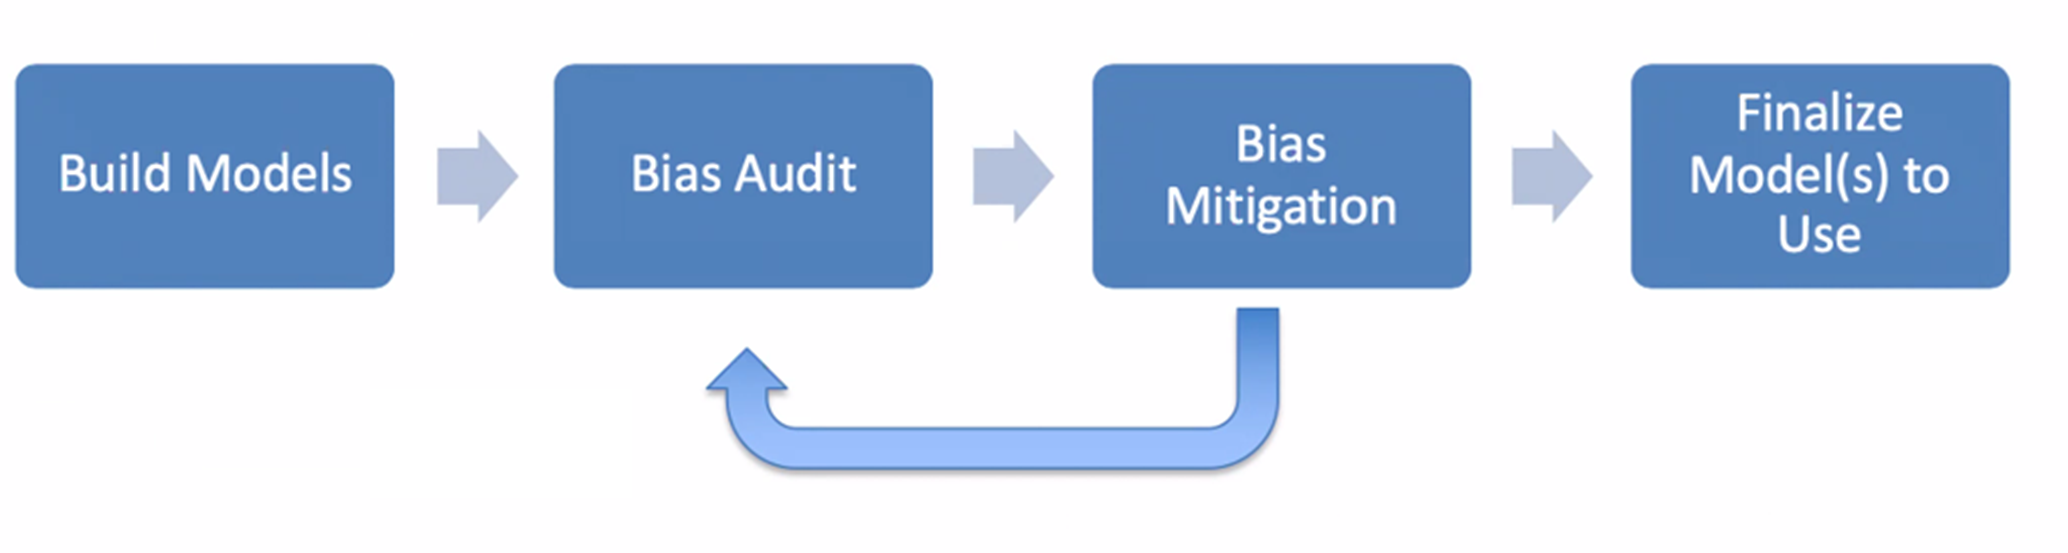